**Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:**

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый. Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [84]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
df_task_1 = pd.read_csv('5_task_1.csv')

In [8]:
df_task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [9]:
df_task_2 = pd.read_csv('5_task_2.csv')

In [10]:
df_task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

**ANOVA**

**Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.**

H0 - что дисперсии гомогенны (различий нет)

In [11]:
A = df_task_1.query('group == "A"').events

In [12]:
B = df_task_1.query('group == "B"').events

In [13]:
C = df_task_1.query('group == "C"').events

In [14]:
ss.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [20]:
#OR

In [23]:
pg.homoscedasticity(data = df_task_1, dv = 'events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


In [24]:
# p-value > 0.05, не отклоняем нулевую гипотезу

**Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.**

Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните  результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?

H0 - распределение нормальное

In [34]:
print(ss.shapiro(df_task_1[df_task_1['group'] == 'A']['events'].sample(1000, random_state=17)))
print(ss.shapiro(df_task_1[df_task_1['group'] == 'B']['events'].sample(1000, random_state=17)))
print(ss.shapiro(df_task_1[df_task_1['group'] == 'C']['events'].sample(1000, random_state=17)))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)
ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)
ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)


In [ ]:
# без sample

In [36]:
print(ss.shapiro(df_task_1[df_task_1['group'] == 'A']['events']))
print(ss.shapiro(df_task_1[df_task_1['group'] == 'B']['events']))
print(ss.shapiro(df_task_1[df_task_1['group'] == 'C']['events']))

ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)
ShapiroResult(statistic=0.9990161061286926, pvalue=1.0504894817131571e-05)
ShapiroResult(statistic=0.9989210963249207, pvalue=3.3885160064528463e-06)


In [39]:
# normaltest
print(ss.normaltest(A))
print(ss.normaltest(B))
print(ss.normaltest(C))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


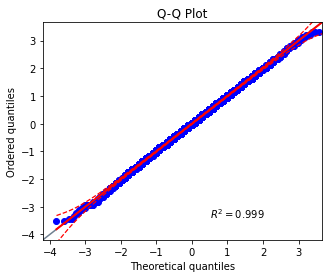

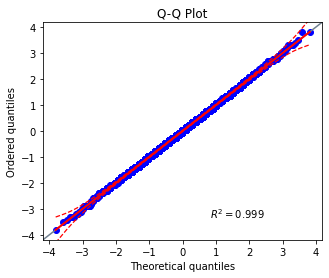

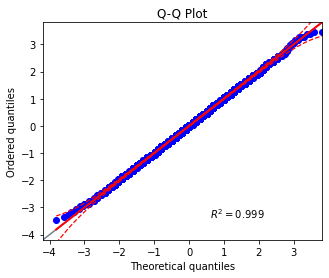

In [52]:
# pg.qqplot
pg.qqplot(A)
pg.qqplot(B)
pg.qqplot(C)

In [46]:
# Распределение во всех группах является нормальным

**Самое время провести тест!**

In [47]:
ss.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [48]:
# pvalue = 0.0, различия в группах есть

**Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.**

Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?

In [53]:
pg.pairwise_tukey(data=df_task_1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [54]:
#OR

In [57]:
pairwise_tukeyhsd(df_task_1.events, df_task_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [60]:
# с поправкой Бонферрони
pg.pairwise_ttests(data=df_task_1, dv='events', between='group', padjust='bonf')

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [61]:
# различия есть во всех попарных комбинациях в группах

Столбец meandiff отражает различие в средних между **второй и первой группой, именно в таком порядке.**

**Так какие картинки в итоге будем использовать?**

**B – Квадратные**

**Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.**

Какой метод скорее всего пригодится в данном случае?

**многофакторный дисперсионный анализ**

**Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп.**

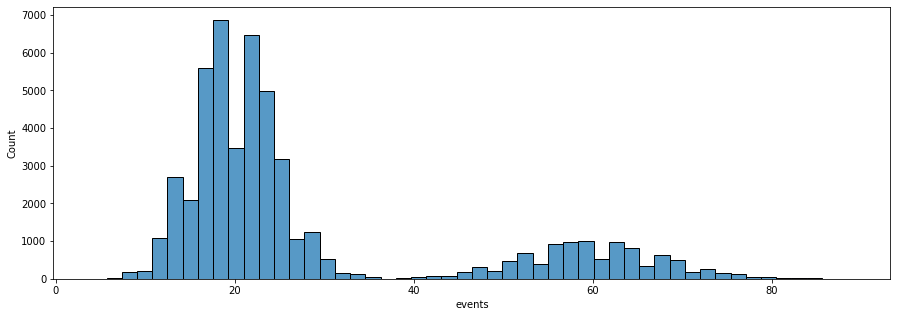

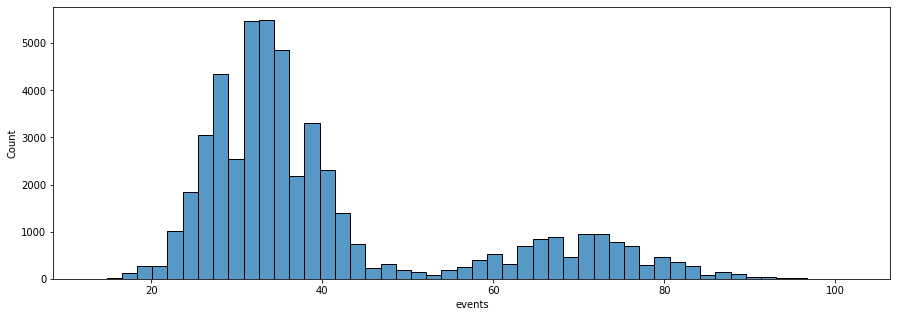

In [98]:
plt.figure(figsize=(15, 5))
df_control = df_task_2.query('group == "control"')
sns.histplot(data=df_control, x='events', bins=50)

plt.figure(figsize=(15, 5))
df_test = df_task_2.query('group == "test"')
sns.histplot(data=df_test, x='events', bins=50)

**Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.**

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

In [104]:
round(df_task_2\
    .groupby(['group', 'segment'], as_index=False)\
    .events.describe(), 2)

group          segment         count            mean          std  \
segment     high      low    high  low     high      low   high    low  high   
group                                                                          
control  control  control    high  low  10000.0  40000.0  59.97  20.03  7.81   
test        test     test    high  low  10000.0  40000.0  69.94  33.03  8.40   

                min         25%         50%         75%          max        
segment   low  high   low  high   low  high   low  high   low   high   low  
group                                                                       
control  4.47  31.0   4.0  55.0  17.0  60.0  20.0  65.0  23.0   89.0  41.0  
test     5.72  40.0  13.0  64.0  29.0  70.0  33.0  76.0  37.0  102.0  59.0

**Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.**

Если вы прибегнете к statsmodels, то какую формулу используете?

**events ~ segment + group + segment:group**

**Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.**

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey

**Между какими группами были обнаружены статистически значимые различия?**

In [111]:
model_main = smf.ols('events ~ segment + group + segment:group', data=df_task_2).fit()
anova_lm(model_main, typ=2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [112]:
df_task_2['combination'] = df_task_2['group'] + ' \ ' + df_task_2['segment']

In [114]:
pairwise_tukeyhsd(df_task_2.events, df_task_2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


In [115]:
# Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой 
# (control \ high - test \ high; control \ low - test \ low )

# Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

#Разница между control/high и test/high составила около 10

**Визуализируйте результаты теста**

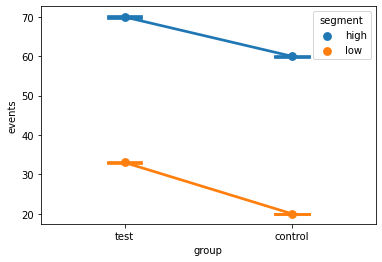

In [120]:
sns.pointplot(x='group', y='events', hue='segment', data=df_task_2, capsize=0.2)

Фактор **group** оказался 
**ЗНАЧИМЫМ**, фактор **segment** – **ЗНАЧИМЫМ**, их **взаимодействие** – **ЗНАЧИМО**. Судя по графику, для всех групп среднее значение **events УВЕЛИЧИЛОСЬ**, поэтому решение: **ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ**